In [18]:
# import os
# RaNDOM
import random
#clock training time
import datetime 
# Numpy for vectorization
import numpy as np
# Tensorflow for ML
import tensorflow as tf
# Pandas for file reading/ visualize data
import pandas as pd
# Seaborn as the great data visualizer
import seaborn as sns
#Matplot to visualize data, also Seaborn and pandas do this
import matplotlib.pyplot as plt
# Inline to show images in jupyter notebook
%matplotlib inline

# Set number of columns to show in the notebook
pd.set_option('display.max_columns', 600)
# Set number of rows to show in the notebook
pd.set_option('display.max_rows', 50)
# Make the graphs a bit prettier
pd.set_option('display.mpl_style', 'default') 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipython-5.2.2-py3.6.egg/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
# Grab the shakespeare data
allData = pd.read_csv('../Data/Shakespeare_data.csv', sep=',')

In [20]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111396 entries, 0 to 111395
Data columns (total 6 columns):
Data-line             111396 non-null int64
Play                  111396 non-null object
Player Line number    111393 non-null float64
Act-Scene-Line        105153 non-null object
Player                111389 non-null object
Player-Line           111396 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 5.1+ MB


In [21]:
allData.columns
allData.values

array([[1, 'Henry IV', nan, nan, nan, 'ACT I'],
       [2, 'Henry IV', nan, nan, nan, 'SCENE I. London. The palace.'],
       [3, 'Henry IV', nan, nan, nan,
        'Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others'],
       ..., 
       [111394, 'A Winters Tale', 38.0, '5.3.182', 'LEONTES',
        "Perform'd in this wide gap of time since first"],
       [111395, 'A Winters Tale', 38.0, '5.3.183', 'LEONTES',
        "We were dissever'd: hastily lead away."],
       [111396, 'A Winters Tale', 38.0, nan, 'LEONTES', 'Exeunt']], dtype=object)

In [22]:
allData.head()

,Data-line,Play,Player Line number,Act-Scene-Line,Player,Player-Line
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [23]:
# Take only the columns we need, this will be a data frame.
lines = allData[["Player-Line"]].astype(str)
print('length of both arrays: ', len(amountLines), ' ', len(linesAndNumbers),' ',  len(lines))

length of both arrays:  111396   111396   111396


In [24]:
# Converting the dataframe to a single string
lines = allData[["Player-Line"]].to_string()
textLines = "".join(lines)
print('text length in number of characters:', len(textLines))

text length in number of characters: 6461025


In [25]:
linesAndNumbers.values

array([[nan, 'ACT I'],
       [nan, 'SCENE I. London. The palace.'],
       [nan,
        'Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others'],
       ..., 
       [38.0, "Perform'd in this wide gap of time since first"],
       [38.0, "We were dissever'd: hastily lead away."],
       [38.0, 'Exeunt']], dtype=object)

In [26]:
wordcld = pd.Series(allData['Player-Line'].tolist()).astype(str)

Total number of lines for training: 6461025


,Data-line,Play,Player Line number,Act-Scene-Line,Player,Player-Line
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


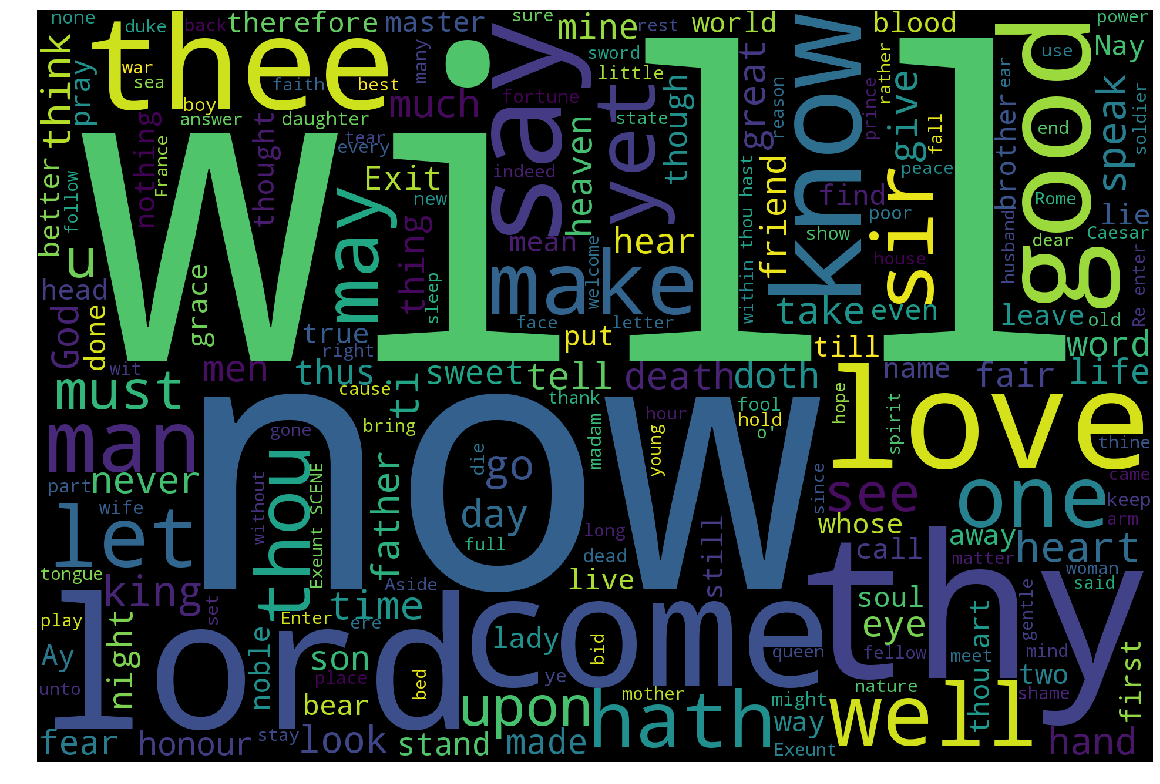

In [27]:
print('Total number of lines for training: {}'.format(len(textLines)))
# Most frequent words in the data set. Just because. Using a beautiful wordcloud
from wordcloud import WordCloud 
cloud = WordCloud(width=1900, height=1280).generate(' '.join(wordcld.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [28]:
chars = sorted(list(set(textLines)))
char_size = len(chars)
print('number of characters:', char_size)
print(chars)
# print(textLines)

number of characters: 77
['\n', ' ', '!', '$', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [29]:
char2id = dict((c, i) for i, c in enumerate(chars))
id2char = dict((i, c) for i, c in enumerate(chars))

In [30]:
#Given a probability of each character, return a likely character, one-hot encoded
def sample(prediction):
    r = random.uniform(0,1)
    s = 0
    char_id = len(prediction) - 1
    for i in range(len(prediction)):
        s += prediction[i]
        if s >= r:
            char_id = i
            break
    char_one_hot = np.zeros(shape=[char_size])
    char_one_hot[char_id] = 1.0
    return char_one_hot

In [31]:
#vectorize our data to feed it into model

len_per_section = 20
skip = 10
sections = []
next_chars = []
#fill sections list with chunks of text, every 10 characters create a new 20 
#character long section
#because we are generating it at a character level
for i in range(0, len(textLines) - len_per_section, skip):
    sections.append(textLines[i: i + len_per_section])
    next_chars.append(textLines[i + len_per_section])
#Vectorize input and output
#matrix of section length by num of characters
X = np.zeros((len(sections), len_per_section, char_size))
#label column for all the character id's, still zero
y = np.zeros((len(sections), char_size))
#for each char in each section, convert each char to an ID
#for each section convert the labels to ids 
for i, section in enumerate(sections):
    for j, char in enumerate(section):
        X[i, j, char2id[char]] = 1
    y[i, char2id[next_chars[i]]] = 1
print(y)

[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]]


In [32]:
batch_size = 256
max_steps = 10000
log_every = 300
test_every = 600
hidden_nodes = 1024
test_start = 'How art thou'
checkpoint_directory = 'ckpt'

#Create a checkpoint directory
if tf.gfile.Exists(checkpoint_directory):
    tf.gfile.DeleteRecursively(checkpoint_directory)
tf.gfile.MakeDirs(checkpoint_directory)

print('training data size:', len(X))
print('approximate steps per epoch:', int(len(X)/batch_size))

training data size: 646101
approximate steps per epoch: 2523


In [33]:
#build our model time
#create computation graph
graph = tf.Graph()
#if multiple graphs, but none here jsut one
with graph.as_default():
    ###########
    #Prep
    ###########
    #Variables and placeholders
    #global_step refer to the number of batches seen by the graph. 
    #Everytime a batch is provided, the weights are updated in the 
    #direction that minimizes the loss. global_step just keeps track 
    #of the number of batches seen so far starts off as 0
    global_step = tf.Variable(0)
    
    #data tensor shape feeding in sections
    data = tf.placeholder(tf.float32, [batch_size, len_per_section, char_size])
    #labels
    labels = tf.placeholder(tf.float32, [batch_size, char_size])
    
    #An LSTM RNN (Long Short Term Memory), consists of 3 gates and an internal state, 
    #This enables the LSTM to capture long-term dependencies. 
    #http://suriyadeepan.github.io/2017-02-13-unfolding-rnn-2/
    #lets build weights and biases for each of the 3 gates and then for the cell state
    
    #tf variables
    #Since we need the weights and biases for our model. 
    #We could imagine treating these like additional inputs, 
    #but TensorFlow has an even better way to handle it: Variable
    #A Variable is a modifiable tensor that lives in TensorFlow's graph of 
    #interacting operations. It can be used and even modified by the computation. 
    #For machine learning applications, one generally has the model parameters be Variables.
    
    #Prep LSTM Operation
    #Input gate: weights for input, weights for previous output, and bias
    
    #tf truncated normal
    #Outputs random values from a truncated normal distribution.
    #The generated values follow a normal distribution with specified mean and 
    #standard deviation, except that values whose magnitude is more than 2 standard deviations
    #from the mean are dropped and re-picked.
    #basically randomly initialized values here
    
    #biases act as an anchor

    w_ii = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_io = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_i = tf.Variable(tf.zeros([1, hidden_nodes]))
    #Forget gate: weights for input, weights for previous output, and bias
    w_fi = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_fo = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_f = tf.Variable(tf.zeros([1, hidden_nodes]))
    #Output gate: weights for input, weights for previous output, and bias
    w_oi = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_oo = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_o = tf.Variable(tf.zeros([1, hidden_nodes]))
    #Memory cell: weights for input, weights for previous output, and bias
    w_ci = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_co = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_c = tf.Variable(tf.zeros([1, hidden_nodes]))
    
    
    #LSTM Cell
    # given input, output, external state, it will return output and state
    #output starts off empty, LSTM cell calculates it
    
    #Since, we have two kinds of states - the internal state ct 
    #and the (exposed) external state st, and since we need both of 
    #them for the subsequent sequential operations, we combine them 
    #into a tensor at each step, and pass them as input to the next 
    #step. This tensor is unpacked into st_1 and ct_1 at the beginning of each step.
    
    
    def lstm(i, o, state):
        
        #these are all calculated seperately, no overlap until....
        #(input * input weights) + (output * weights for previous output) + bias
        input_gate = tf.sigmoid(tf.matmul(i, w_ii) + tf.matmul(o, w_io) + b_i)
        #(input * forget weights) + (output * weights for previous output) + bias
        forget_gate = tf.sigmoid(tf.matmul(i, w_fi) + tf.matmul(o, w_fo) + b_f)
        #(input * output weights) + (output * weights for previous output) + bias
        output_gate = tf.sigmoid(tf.matmul(i, w_oi) + tf.matmul(o, w_oo) + b_o)
        #(input * internal state weights) + (output * weights for previous output) + bias
        memory_cell = tf.sigmoid(tf.matmul(i, w_ci) + tf.matmul(o, w_co) + b_c)
        
        #...now! multiply forget gate * given state    +  input gate * hidden state
        state = forget_gate * state + input_gate * memory_cell
        #squash that state with tanh nonlin (Computes hyperbolic tangent of x element-wise)
        #multiply by output
        output = output_gate * tf.tanh(state)
        #return 
        return output, state
    
    ###########
    #Operation
    ###########
    #LSTM
    #both start off as empty, LSTM will calculate this
    output = tf.zeros([batch_size, hidden_nodes])
    state = tf.zeros([batch_size, hidden_nodes])

    #unrolled LSTM loop
    #for each input set
    for i in range(len_per_section):
        #calculate state and output from LSTM
        output, state = lstm(data[:, i, :], output, state)
        #to start, 
        if i == 0:
            #store initial output and labels
            outputs_all_i = output
            labels_all_i = data[:, i+1, :]
        #for each new set, concat outputs and labels
        elif i != len_per_section - 1:
            #concatenates (combines) vectors along a dimension axis, not multiply
            outputs_all_i = tf.concat([outputs_all_i, output], 0)
            labels_all_i = tf.concat([labels_all_i, data[:, i+1, :]], 0)
        else:
            #final store
            outputs_all_i = tf.concat([outputs_all_i, output], 0)
            labels_all_i = tf.concat([labels_all_i, labels], 0)
        
    #Classifier
    #The Classifier will only run after saved_output and saved_state were assigned.
    
    #calculate weight and bias values for the network
    #generated randomly given a size and distribution
    w = tf.Variable(tf.truncated_normal([hidden_nodes, char_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([char_size]))
    #Logits simply means that the function operates on the unscaled output 
    #of earlier layers and that the relative scale to understand the units 
    #is linear. It means, in particular, the sum of the inputs may not equal 1, 
    #that the values are not probabilities (you might have an input of 5).
    logits = tf.matmul(outputs_all_i, w) + b
    
    #logits is our prediction outputs, lets compare it with our labels
    #cross entropy since multiclass classification
    #computes the cost for a softmax layer
    #then Computes the mean of elements across dimensions of a tensor.
    #average loss across all values
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_all_i, logits=logits))

    #Optimizer
    #minimize loss with graident descent, learning rate 10,  keep track of batches
    optimizer = tf.train.GradientDescentOptimizer(10.).minimize(loss, global_step=global_step)
    
    ###########
    #Test
    ###########
    test_data = tf.placeholder(tf.float32, shape=[1, char_size])
    test_output = tf.Variable(tf.zeros([1, hidden_nodes]))
    test_state = tf.Variable(tf.zeros([1, hidden_nodes]))
    
    #Reset at the beginning of each test
    reset_test_state = tf.group(test_output.assign(tf.zeros([1, hidden_nodes])), 
                                test_state.assign(tf.zeros([1, hidden_nodes])))

    #LSTM
    test_output, test_state = lstm(test_data, test_output, test_state)
    test_prediction = tf.nn.softmax(tf.matmul(test_output, w) + b)

In [ ]:
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    offset = 0
    saver = tf.train.Saver()
    
    for step in range(max_steps):
        offset = offset % len(X)
        if offset <= (len(X) - batch_size):
            batch_data = X[offset: offset + batch_size]
            batch_labels = y[offset: offset + batch_size]
            offset += batch_size
        else:
            to_add = batch_size - (len(X) - offset)
            batch_data = np.concatenate((X[offset: len(X)], X[0: to_add]))
            batch_labels = np.concatenate((y[offset: len(X)], y[0: to_add]))
            offset = to_add
        _, training_loss = sess.run([optimizer, loss], feed_dict={data: batch_data, labels: batch_labels})
        
        if step % log_every == 0:
            print('training loss at step %d: %.2f (%s)' % (step, training_loss, datetime.datetime.now()))

            if step % test_every == 0:
                reset_test_state.run()
                test_generated = test_start
                
                for i in range(len(test_start) - 1):
                    test_X = np.zeros((1, char_size))
                    test_X[0, char2id[test_start[i]]] = 1.
                    _ = sess.run(test_prediction, feed_dict={test_data: test_X})
                
                test_X = np.zeros((1, char_size))
                test_X[0, char2id[test_start[-1]]] = 1.
                
                for i in range(500):
                    prediction = test_prediction.eval({test_data: test_X})[0]
                    next_char_one_hot = sample(prediction)
                    next_char = id2char[np.argmax(next_char_one_hot)]
                    test_generated += next_char
                    test_X = next_char_one_hot.reshape((1, char_size))
                    
                print('=' * 80)
                print(test_generated)
                print('=' * 80)
                
                saver.save(sess, checkpoint_directory + '/model', global_step=step)

training loss at step 0: 4.29 (2017-03-24 12:16:01.036784)
How art thou                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    


In [ ]:
# To try your own text uncomment this! But note the model needs to be trained again.
'''
test_start = 'Text goes here'

with tf.Session(graph=graph) as sess:
    #init graph, load model
    tf.global_variables_initializer().run()
    model = tf.train.latest_checkpoint(checkpoint_directory)
    saver = tf.train.Saver()
    saver.restore(sess, model)

    #set input variable to generate chars from
    reset_test_state.run() 
    test_generated = test_start

    #for every char in the input sentennce
    for i in range(len(test_start) - 1):
        #initialize an empty char store
        test_X = np.zeros((1, char_size))
        #store it in id from
        test_X[0, char2id[test_start[i]]] = 1.
        #feed it to model, test_prediction is the output value
        _ = sess.run(test_prediction, feed_dict={test_data: test_X})

    
    #where we store encoded char predictions
    test_X = np.zeros((1, char_size))
    test_X[0, char2id[test_start[-1]]] = 1.

    #lets generate 500 characters
    for i in range(500):
        #get each prediction probability
        prediction = test_prediction.eval({test_data: test_X})[0]
        #one hot encode it
        next_char_one_hot = sample(prediction)
        #get the indices of the max values (highest probability)  and convert to char
        next_char = id2char[np.argmax(next_char_one_hot)]
        #add each char to the output text iteratively
        test_generated += next_char
        #update the 
        test_X = next_char_one_hot.reshape((1, char_size))

    print(test_generated)
'''